To understand how ANEMO works with a function created by the user we will use fct_velocity present in ANEMO

In [1]:
from ANEMO import ANEMO
from ANEMO import read_edf

import numpy as np

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Retrieving the data

In [2]:
datafile = 'data/enregistrement_AM_2017-10-23_100057.asc'

try:
    data = read_edf(datafile, 'TRIALID')
except:
    from urllib.request import urlopen
    url = 'https://github.com/chloepasturel/AnticipatorySPEM/raw/master/data/enregistrement_AM_2017-10-23_100057.asc'
    
    with open(datafile, 'wb') as f:
        f.write(urlopen(url).read())
    urlopen(url).close()
    f.close()
    data = read_edf(datafile, 'TRIALID')
    


expfile = 'data/enregistrement_AM_2017-10-23_100057.pkl'

try :
    with open(expfile, 'rb') as fichier :
        exp = pickle.load(fichier, encoding='latin1')
except :
    from urllib.request import urlopen
    url = 'https://github.com/chloepasturel/AnticipatorySPEM/raw/master/data/enregistrement_AM_2017-10-23_100057.pkl'
    
    with open(expfile, 'wb') as f:
        f.write(urlopen(url).read())
    urlopen(url).close()
    f.close()
    with open(expfile, 'rb') as fichier :
        exp = pickle.load(fichier, encoding='latin1')

# Fonction

In [3]:
def fct_veve (x, dir_target, start_anti, v_anti, latence, tau, maxi, do_whitening) :


    v_anti = v_anti/1000 # pour passer de sec à ms
    time = x # np.arange(len(x))
    vitesse = []
    y = 0

    for t in range(len(time)):

        if start_anti >= latence :
            if time[t] < latence :
                vitesse.append(0)
            else :
                vitesse.append(dir_target*maxi*(1-np.exp(-1/tau*(time[t]-latence))))
        else :
            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    vitesse.append((time[t]-start_anti)*v_anti)
                    y = (time[t]-start_anti)*v_anti
                else :
                    vitesse.append(dir_target*maxi*(1-np.exp(-1/tau*(time[t]-latence)))+y)

    if do_whitening is True:
        vitesse = whitening(vitesse)

    return vitesse

# Param_Fit

In [4]:
A = ANEMO(exp)

In [5]:
t_sup = 10

In [6]:
def generation_param_fit(block, trial) :
    data_trial = data[trial+block*exp['N_trials']]
    arg = A.arg(data_trial, trial=trial, block=block)


    param_fit=[{'name':'tau', 'value':15., 'min':13., 'max':80., 'vary':True},
               {'name':'maxi', 'value':15, 'min':1., 'max':40., 'vary':True},
               {'name':'dir_target', 'value':arg.dir_target, 'min':None, 'max':None, 'vary':False},
               {'name':'v_anti', 'value':0., 'min':-40., 'max':40., 'vary':True},
               {'name':'latence', 'value':arg.TargetOn-arg.t_0+100, 'min':arg.TargetOn-arg.t_0+75, 'max':len(arg.trackertime), 'vary':True},
               {'name':'start_anti', 'value':arg.TargetOn-arg.t_0-100, 'min':arg.StimulusOf-arg.t_0-200, 'max':arg.TargetOn-arg.t_0+75, 'vary':True}]


    trackertime = arg.trackertime
    inde_vars={'x':np.arange(len(trackertime))}
    
    return param_fit, inde_vars

# Demo

In [7]:
Plot = ANEMO.Plot(exp)
Fit = ANEMO.Fit(exp)

In [8]:
# number of the trial and block that you want to display with plot_data and plot_fit
trial=1
block=1

# for plot_Full_data and Fit_full
# display the first ten trials divided into two blocks of 5 trials each
data1 = data[:10]
N_blocks = 2
N_trials = 5

In [9]:
x = np.arange(0, 1500, 1)
param_defaut = {'dir_target' : -1,
                'start_anti' : 650,
                'v_anti' : -20,
                'latence' : 850,
                'tau' : 15,
                'maxi' : 15,
                'do_whitening' : False
               }

In [12]:
def demo(data_show):
    fig, axs = Plot.plot_equation(fct_veve(x, **param_defaut))
    plt.show()
    fig, axs = Plot.plot_data(data, 'velocity', trial, block)
    plt.show()
    
    param_fit, inde_vars = generation_param_fit(block, trial)
    fig, axs = Plot.plot_fit(data, equation=fct_veve, fitted_data='velocity', trials=trial,
                             block=block, param_fit=param_fit,
                             inde_vars=inde_vars, time_sup=None)
    plt.show()
    
    
    print('\nPlot Full Fit\n---------------\n')
    param = Fit.Fit_full(data1, equation=fct_veve, plot=True,
                         param_fit=param_fit, inde_vars=inde_vars,
                         N_blocks=N_blocks, N_trials=N_trials,
                         list_param_enre=['start_anti', 'v_anti'],
                         file_fig='result/Fit_fonction', time_sup=None)
    print('\nfigure fit saved in result/Fit_fonction')

    # saves the fit parameters
    with open('result/param_Fit_fonction_AM.pkl', 'wb') as fichier:
        f = pickle.Pickler(fichier)
        f.dump(param)
    print('param fit saved in result/param_Fit_fonction_AM\n------------------------------\n')

## Demo velocity

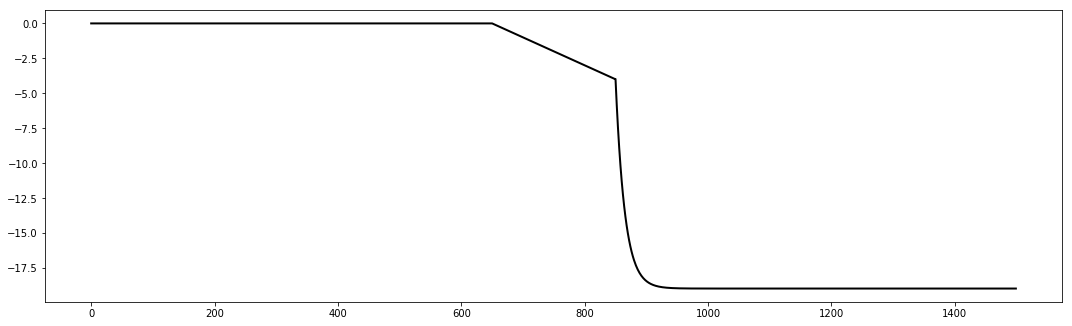

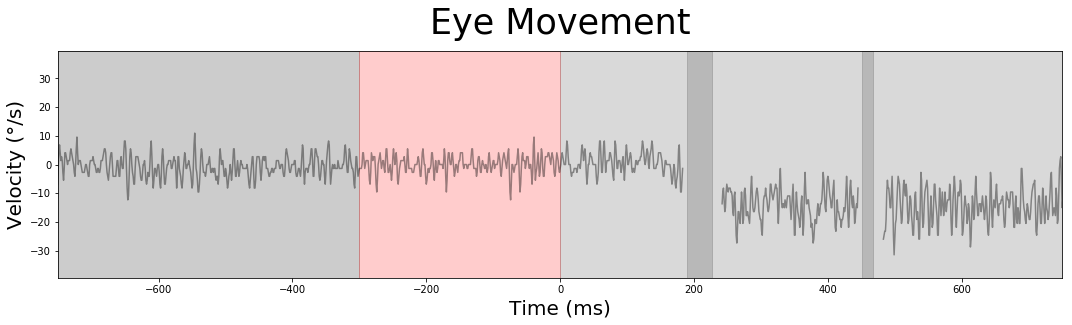

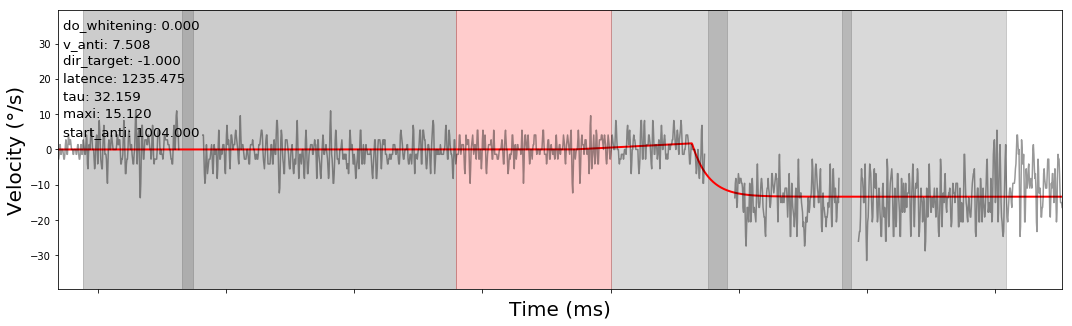


Plot Full Fit
---------------

block, trial =  0 0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1958 but corresponding boolean dimension is 1860

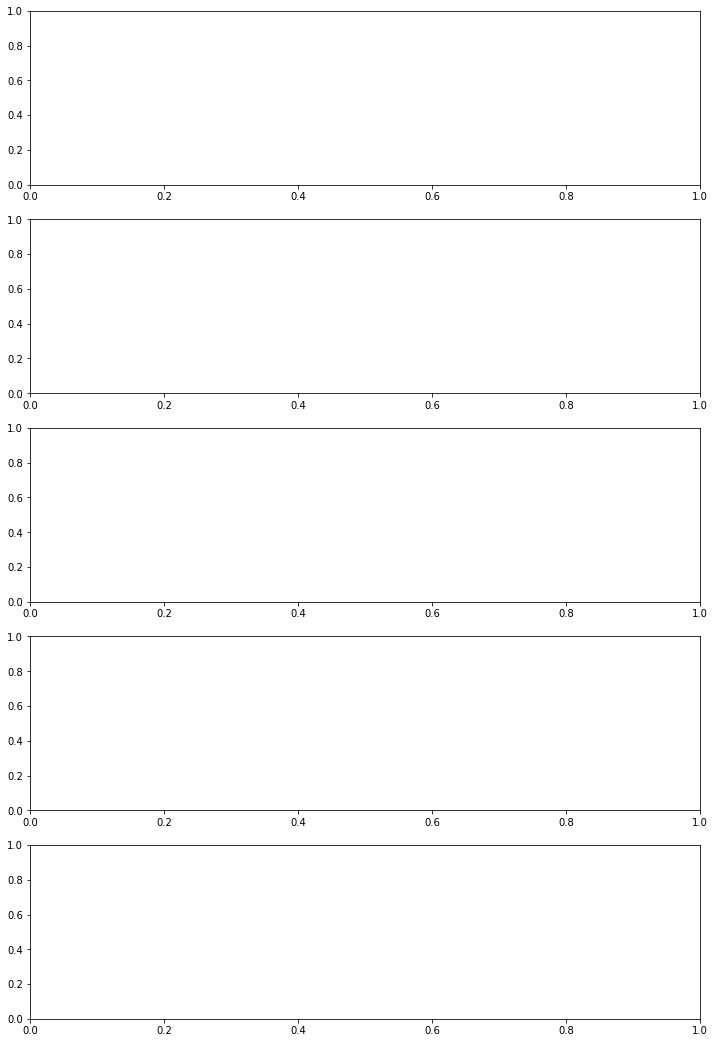

In [13]:
demo('velocity')